# Internal Tide and BALanced Turbulence configuration (ITBALT), overview

Next things to try:

...

In [2]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op

In [3]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(jobs=2)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41617 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


## Load data

In [4]:
#root_path = '/home/datawork-lops-osi/equinox/itbalt/'
root_path = '/home1/scratch/aponte/'
#root_path = '/home/c11-data/Test_aponte/fsturb/'

run = 'fsturb_m1_4km_0a100j/'
#run = 'fsturb_m0_a1m2_4km_0a1000j/'
m, a = 1, '1m2'
#m, a = 0, '5m2'
#run = 'fsturb_m{}_a'.format(m)+a+'_4km_0a1000j/'

r = pp.Run(root_path+run, open_nc=['surf', 'his'],verbose=True)
r['surf'] = r['surf'].rename({'time_instant': 'time'})
r['his'] = r['his'].rename({'time_counter': 'time'})
pout = r.params_output

Analysing directory /home1/scratch/aponte/fsturb_m1_4km_0a100j/
Found 1 segments
Found 1 grid files
Found 2 surf files
Found 5 his files
Detected time step of 300.0 s
Detected theta_s = 5.0
Detected theta_b = 0.0
Detected Hc = 100.0 m
Detected rho0 = 1000.0 kg/m^3
Detected H = 4000.0 m
Found 9 columns in output.mpi:
['STEP', 'time[DAYS]', 'KINETIC_ENRG', 'POTEN_ENRG', 'TOTAL_ENRG', 'NET_VOLUME', 'trd', 'ENSTROPHY', 'BTKIN_ENRG']
Opening NC datasets:  ['grid', 'surf', 'his']
Grid size: (L ,M, N) = (258, 722, 50)


In [32]:
'azdaz'.strip

<function str.strip(chars=None, /)>

In [60]:
from glob import glob

# load vmodes

t = 1
def open_vmfile(f, r):
    ds = xr.open_dataset(f)
    for d in ds.dims:
        if ds[d].size==r.N:
            ds = ds.rename({d: 's_rho'})
            ds['s_rho'] = r['grid']['s_rho']
        elif ds[d].size==r.N+1:
            ds = ds.rename({d: 's_w'})
            ds['s_w'] = r['grid']['s_w']
        else:
            ds = ds.rename({d: 'mode'})
            ds['mode'] = np.arange(0,ds['mode'].size)
    ds = ds.rename(array=f.split('/')[-1].strip('vmodes_').replace('.nc',''))
    return ds

ds_vm = xr.merge([open_vmfile(f,r) for f in glob(r.dirname+'t{}/vmodes*.nc'.format(t))])
#ds_vm.set_coords('z_rho','z_w')

In [67]:
ds_vm

<xarray.Dataset>
Dimensions:  (mode: 5, s_rho: 50, s_w: 51)
Coordinates:
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
  * s_w      (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
  * mode     (mode) int64 0 1 2 3 4
Data variables:
    T0       (s_rho) float64 ...
    zr       (s_rho) float64 ...
    phiw     (mode, s_w) float64 ...
    N2       (s_w) float64 ...
    zw       (s_w) float64 ...
    phiuv    (mode, s_rho) float64 ...
    c        (mode) float64 ...
    phir     (mode, s_w) float64 ...

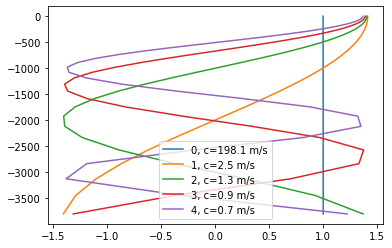

In [76]:
for m in ds_vm.mode:
    plt.plot(ds_vm.phiuv.sel(mode=m), ds_vm.zr, label='{}, c={:.1f} m/s'.format(m.values, ds_vm.c.sel(mode=m).values))
plt.legend()

---

## utils

In [4]:
def plot_Fy(p, ax=None, scale=1, ls='--', color='k', **kwargs):
    #p = r.params_output
    ymid = p['fst_ymid']*scale
    ywid = p['fst_ywid']*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

In [5]:
def get_cmap_colors(Nc, cmap='plasma'):
    
    import matplotlib.colors as colors
    import matplotlib.cm as cmx

    scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=Nc),
                                   cmap=cmap)
    return [scalarMap.to_rgba(i) for i in range(Nc)]

In [6]:
# this should move somewhere useful

import os
from dask import delayed
import threading

def gen_fig(da, i=0, test=False,
            overwrite=True, fig_suffix=None, fig_dir=None, 
            figsize=(4,5), ax_kwargs={}, **plt_kwargs):
    """ Generate a figure, make a plot and store figure. 
    May be distributed across workers
    
    Parameters
    ----------
    
    da: xarray DataArray
        Variable containing data that will be plotted
    
    i: integer, optional
        Index that will be used in filename. Default is 0
        
    test: boolean, optional
        Flag to test figure generation. Default is False
        
    overwrite: boolean, optional
        Turn overwrite existing figure files. Default is True
        
    fig_suffix: str, optional
        Suffix of figure files. Default to da name
        
    fig_dir: str, optional
        Directory where figures will be stored. 
        Default to figs in user scratch directory
        
    figsize: tuple, optional
        Figure size. Default to (4,5)
        
    ax_kwargs: dict, optional
        Dictionnary of keyword arguments passed on the axis
        
    **plt_kwargs:
        Keyword arguments passed on xarray plot call.
    
    """
    
    if fig_dir is None:
        fig_dir = os.environ['SCRATCH']+'/figs/'
        
    if test:
        da = da.isel(time=i)
        
    if fig_suffix is None:
        fig_suffix = da.name
        
    figname = fig_dir+fig_suffix+'_t%05d' %(i)+'.png'
    
    if not os.path.isfile(figname) or overwrite:
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            if not test:
                plt.switch_backend('agg')    
            #
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(1,1,1)
            #
            plt_atom(da, ax, ax_kwargs, **plt_kwargs)
            #
            if not test:
                fig.savefig(figname, bbox_inches = 'tight')
                plt.close()
            #
            m = 1.
    else:
        m = -1.
    if not test:
        return m

def fig_wrapper(da, Nt=None,Nb=None, **get_kwargs):
    """ wrap figure generation in delayed objects that can be distributed to
    workers. Send by batches of Nb figures.
    
    Parameters
    ----------
    
    da: Dask array
        contain data to be plotted.
        
    Nt: int, optional
        Number of figures generated. Default to entire dataset.

    Nb: int, optional
        Number of figures to generate in each batch. Default to number of 
        available threads.
        
    **kwargs: optional
        Keyword arguments passed on to get_fig.
    
    """
    if Nt is None:
        Nt = da.time.size
    if Nb is None:
        Nb = len(client.nthreads())
    #
    rg = range(0,Nt)
    II = np.array_split(rg,len(rg)/Nb)
    #
    print('%d batches to be done'%len(II))
    for I in II:
        print(' batch %d-%d'%(I[0],I[-1]))
        values = [delayed(gen_fig)(da.isel(time=i), i, **get_kwargs) for i in I]
        futures = client.compute(values)
        results = client.gather(futures)

---

## bulk statistics

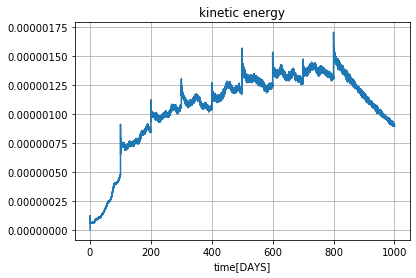

In [64]:
ax = r.stats['KINETIC_ENRG'].plot(title='kinetic energy')
ax.grid()

In [65]:
ds = r['surf']
ds['u2'] = ds.u**2
ds['v2'] = ds.v**2
ds_mean = ds.mean(dim=['x_rho','x_u','time']).persist()

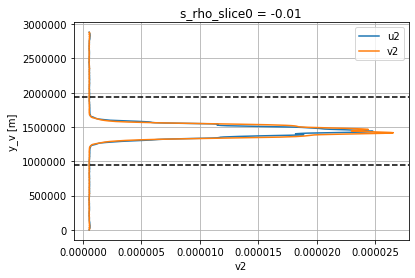

In [66]:
ax = plt.subplot(111)
ds_mean.u2.plot(y='y_rho', ax=ax, label='u2')
ds_mean.v2.plot(y='y_v', ax=ax, label='v2')
ax.legend()
ax.grid()
plot_Fy(pout)

In [67]:
u2_meanx = (r['surf'].u**2).mean(dim=['x_u']).persist()

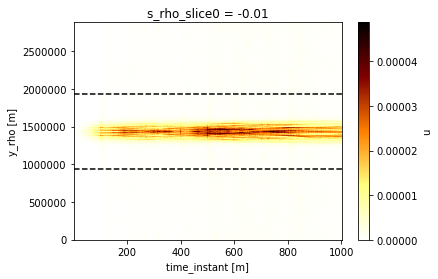

In [68]:
u2_meanx.plot(x='time', y='y_rho', cmap='afmhot_r') #.values.shape
plot_Fy(pout)

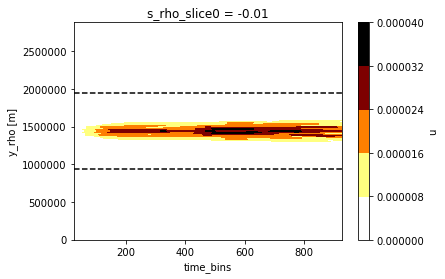

In [69]:
toplt = u2_meanx.groupby_bins('time',np.arange(0,1000,50)).mean('time').squeeze()
toplt.time_bins.values = [t.values.item().mid for t in toplt.time_bins] # contourf won't work otherwise
toplt.plot.contourf(x='time_bins', y='y_rho', cmap='afmhot_r')
plot_Fy(pout)

--- 

## pictures

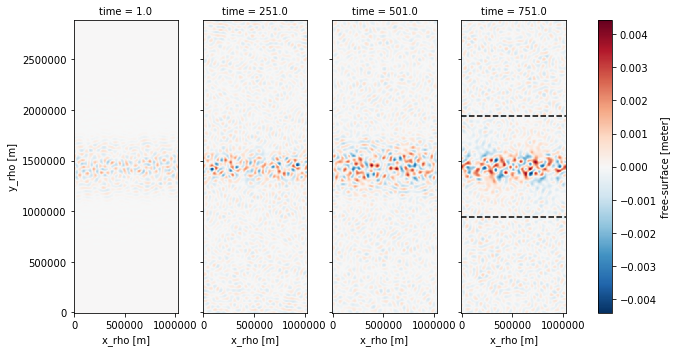

In [70]:
hdl = (r['surf']['ssh'].sel(time=slice(0,1000,250))
         .plot(x='x_rho', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(pout, ax=hdl.axes[0,-1])

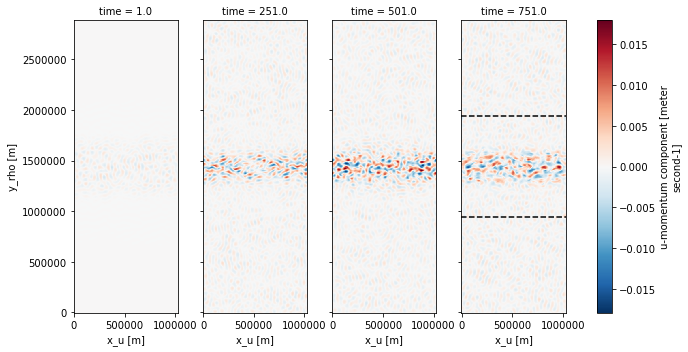

In [71]:
hdl = (r['surf']['u'].sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_rho', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

In [72]:
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.derivative(u, 'eta') + r.xgrid.derivative(v, 'xi'))

AttributeError: 'Grid' object has no attribute '_metrics'

In [73]:
# hardcode derivative: not ideal
u, v = r['surf']['u'], r['surf']['v']
zeta = (-r.xgrid.diff(u, 'eta') + r.xgrid.diff(v, 'xi'))/4e3

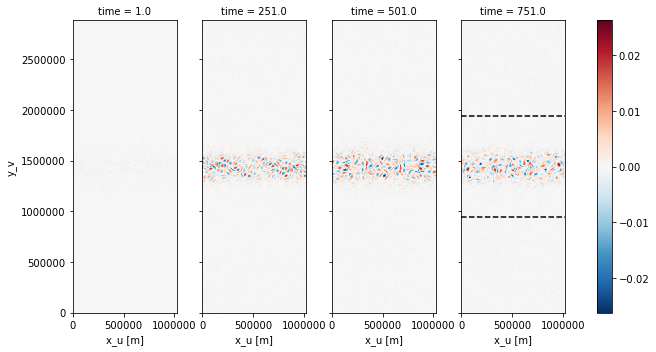

In [74]:
f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
hdl = ((zeta/f_zeta).sel(time=slice(0,1000,250))
         .plot(x='x_u', y='y_v', col='time', col_wrap=4, 
               subplot_kws={'aspect':'equal'},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

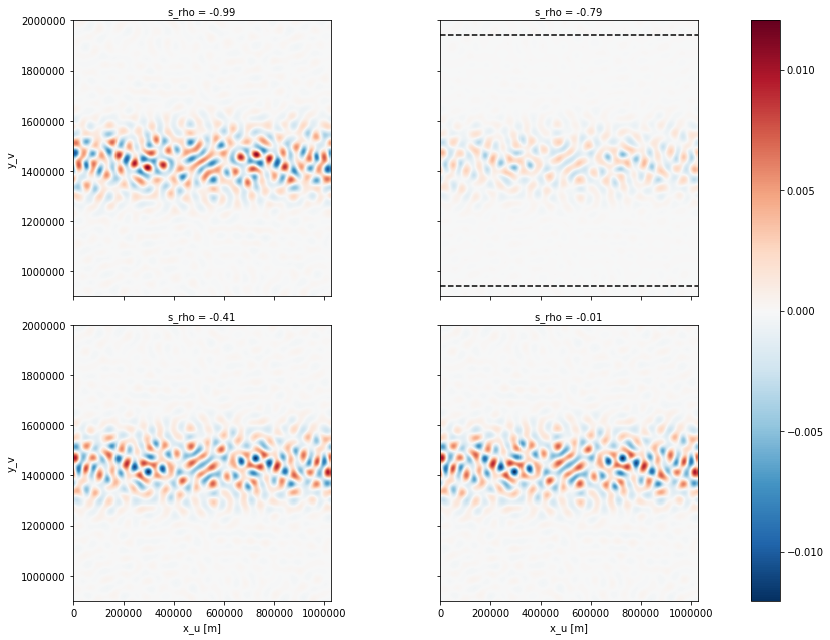

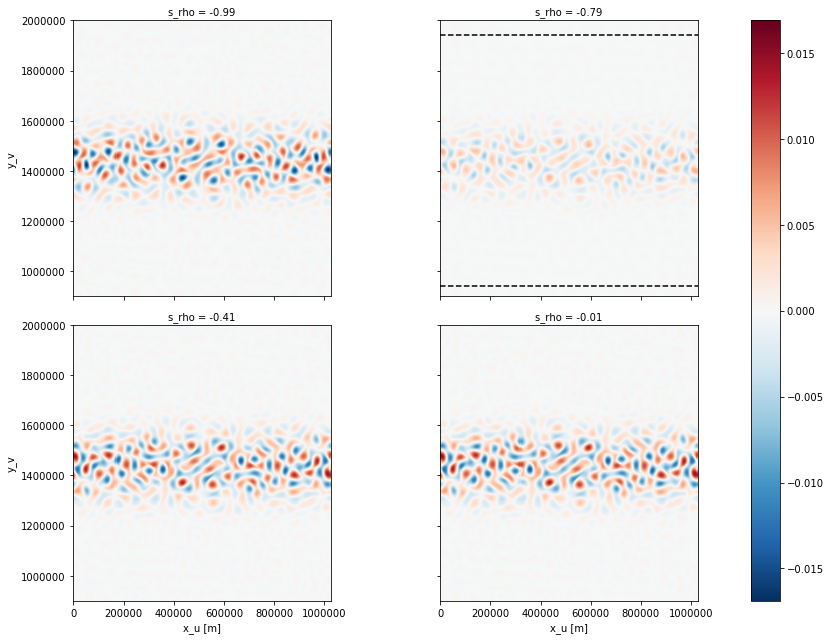

In [75]:
# hardcode derivative: not ideal
u, v = r['his']['u_t_dirac'], r['his']['v_t_dirac']
zeta_his = (-r.xgrid.diff(u, 'eta') + r.xgrid.diff(v, 'xi'))/4e3

for t in [50, 100]:

    f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
    hdl = ((zeta_his/f_zeta).sel(time=t, s_rho=[-1,-.8,-.4, 0.], method='nearest')
             .plot(x='x_u', y='y_v', col='s_rho', col_wrap=2, 
                   subplot_kws={'aspect':'equal'},
                   aspect=.5, figsize=(15,9),
                   ylim=(900*1e3, 2000*1e3))
    )
    plot_Fy(pout, ax=hdl.axes[0,-1])


<Figure size 432x288 with 0 Axes>

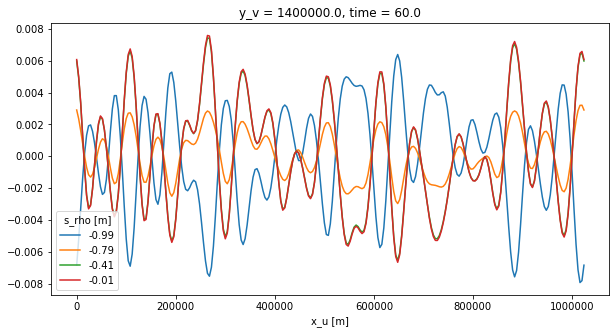

<Figure size 432x288 with 0 Axes>

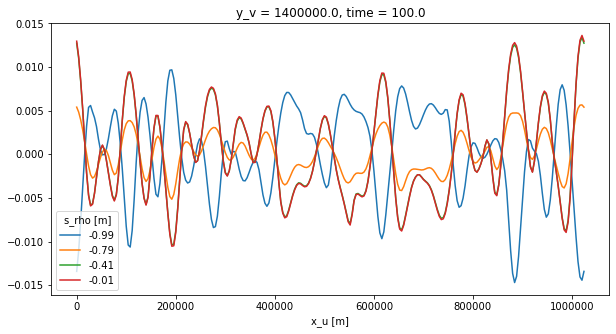

<Figure size 432x288 with 0 Axes>

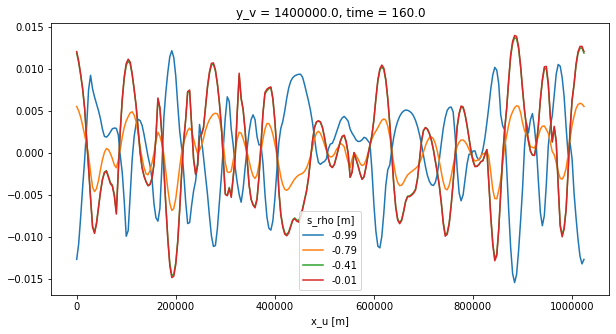

In [77]:
for t in [50, 100, 150]:

    f_zeta = r.xgrid.interp(r.xgrid.interp(r['grid'].f, 'eta'), 'xi')
    plt.figure()
    hdl = ((zeta_his/f_zeta).sel(time=t, s_rho=[-1,-.8,-.4, 0.], y_v=1400e3, method='nearest')
             .plot(x='x_u', hue='s_rho', figsize=(10,5)) #col='s_rho', col_wrap=2
    )

---

## vertical slices

In [78]:
# gridop elementary transforms such as that below need to be updated
# need to add wrapper in postp object
def rho2u(v, r):
    """
    interpolate horizontally variable from rho to u point
    """
    grid = r.xgrid
    var = grid.interp(v,'xi')
    var = var.assign_coords(x_u=grid.interp(v.x_rho,'xi'))
    var.attrs = v.attrs
    return var.rename(v.name)

In [79]:
def get_z(run, zeta=None, h=None, vgrid='r', hgrid='r', vtrans=None, zfirst=False):
    ''' compute vertical coordinates
        zeta should have the size of the final output
        vertical coordinate is first in output
    '''

    try:
        ds = run.ds['grid']
    except Exception:
        ds = run.ds['his']
    N = run.N
    hc = run.params_input['Hc']

    _h = ds.h if h is None else h
    _zeta = 0*ds.h if zeta is None else zeta

    # swith horizontal grid if needed (should we use grid.interp instead?)
    if hgrid in ['u','v']:
        funtr = eval("rho2"+hgrid)
        if zeta is None:
            _zeta = funtr(_zeta, ds)
        _h = funtr(_h, ds)

    # determine what kind of vertical corrdinate we are using (NEW_S_COORD)
    if vtrans is None:
        vtrans = ds.Vtransform.values
    else:
        if isinstance(vtrans, str):
            if vtrans.lower()=="old":
                vtrans = 1
            elif vtrans.lower()=="new":
                vtrans = 2
            else:
                raise ValueError("unable to understand what is vtransform")

    sc=ds['sc_'+vgrid]
    cs=ds['Cs_'+vgrid]

    if vtrans == 2:
        z0 = (hc * sc + _h * cs) / (hc + _h)
        z = _zeta + (_zeta + _h) * z0
    else:
        z0 = hc*sc + (_h-hc)*cs
        #z = z0 + _zeta*(1+z0/_h)
        z = _zeta*(1+z0/_h) + z0

    zdim = "s_"+vgrid.replace('r','rho')
    if zfirst and z.dims[0] != zdim:
        z = z.transpose(*(zdim,)+_zeta.dims)
    return z.rename('z_'+vgrid)                

In [80]:
z_u = get_z(r, 
            zeta=rho2u(r['his'].ssh_t_dirac, r), 
            h=rho2u(r['grid'].h, r))
#z_u = op.get_z(r, zeta=r['his'].ssh_t_dirac, hgrid='u')
#z_u = op.get_z(r, zeta=r['his'].ssh_t_dirac, h='u')

In [81]:
z_u

<xarray.DataArray 'z_r' (time: 50, y_rho: 722, x_u: 257, s_rho: 50)>
dask.array<add, shape=(50, 722, 257, 50), dtype=float32, chunksize=(1, 722, 257, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 20.0 40.0 60.0 80.0 ... 940.0 960.0 980.0 1e+03
  * y_rho    (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
  * x_u      (x_u) float32 0.0 4000.0 8000.0 ... 1016000.0 1020000.0 1024000.0
  * s_rho    (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01

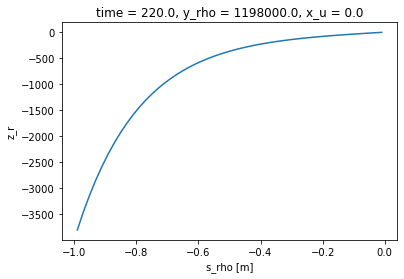

In [82]:
z_u.isel(x_u=0, y_rho=300, time=10).plot()

In [83]:
ds = r['his'].assign_coords(z_u = z_u)
ds.u_t_dirac

<xarray.DataArray 'u_t_dirac' (time: 50, s_rho: 50, y_rho: 722, x_u: 257)>
dask.array<concatenate, shape=(50, 50, 722, 257), dtype=float32, chunksize=(1, 1, 722, 257), chunktype=numpy.ndarray>
Coordinates:
  * x_u           (x_u) float32 0.0 4000.0 8000.0 ... 1020000.0 1024000.0
  * y_rho         (y_rho) float32 -2000.0 2000.0 6000.0 ... 2878000.0 2882000.0
    y_u           (y_rho) float32 dask.array<chunksize=(722,), meta=np.ndarray>
  * s_rho         (s_rho) float32 -0.99 -0.97 -0.95 -0.93 ... -0.05 -0.03 -0.01
    time_instant  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time          (time) float64 20.0 40.0 60.0 80.0 ... 940.0 960.0 980.0 1e+03
    z_u           (time, y_rho, x_u, s_rho) float32 dask.array<chunksize=(1, 722, 257, 50), meta=np.ndarray>
Attributes:
    online_operation:    instant
    interval_operation:  2 d
    interval_write:      20 d
    cell_methods:        time: point (interval: 2 d)

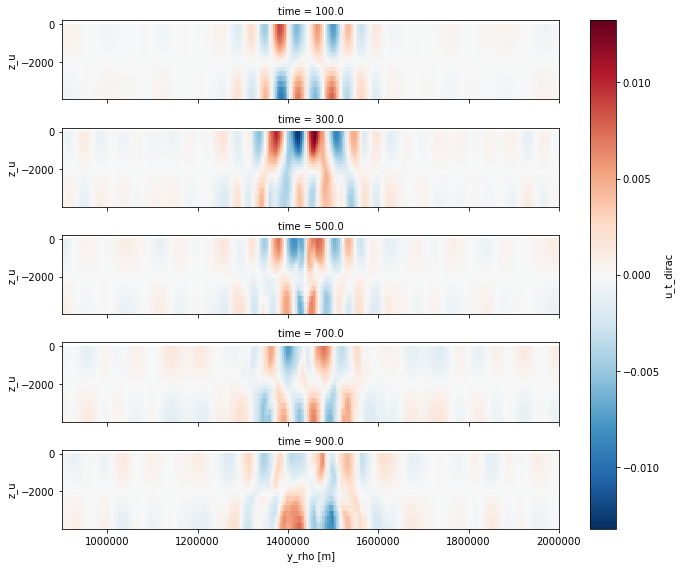

In [84]:
(ds.u_t_dirac
 .isel(x_u=0).sel(time=np.arange(100,1000,200), method='nearest')
 .plot(x='y_rho', y='z_u', 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col='time', col_wrap=1)
)

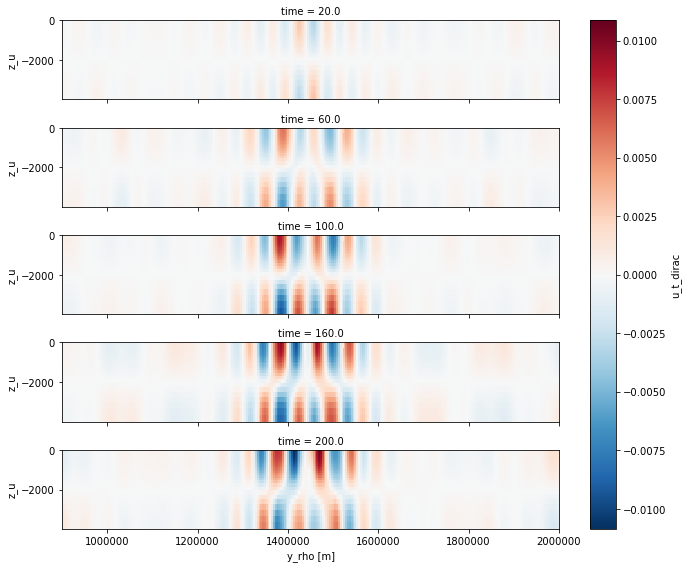

In [85]:
(ds.u_t_dirac
 .isel(x_u=0).sel(time=np.arange(0,250,50), method='nearest')
 .plot(x='y_rho', y='z_u', 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col='time', col_wrap=1)
)

In [86]:
lds = (ds.u_t_dirac
       .isel(x_u=0)
       .sel(y_rho=1400e3, time=np.arange(100,1000,100), method='nearest')
      ).persist()

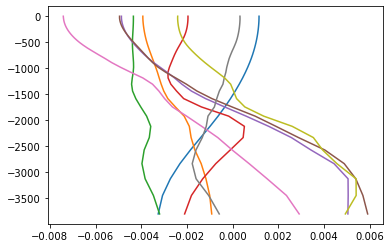

In [87]:
for t in lds.time:
    plt.plot(lds.sel(time=t), lds.sel(time=t).z_u)

ValueError: x and y must have same first dimension, but have shapes (50, 9) and (9, 50)

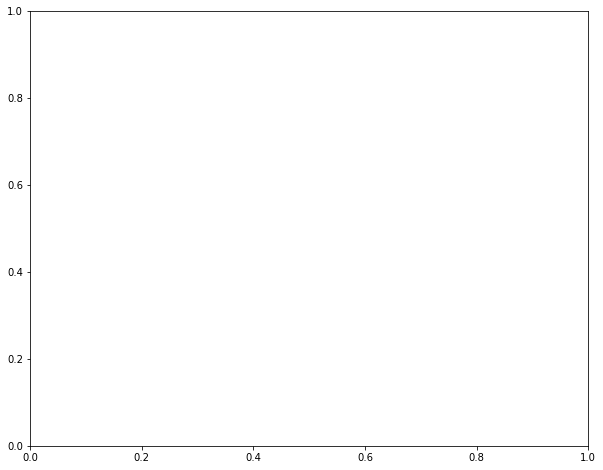

In [46]:
(ds.u_t_dirac
 .isel(x_u=0).sel(y_rho=1400e3, time=np.arange(100,1000,100), method='nearest')
 .plot.line(y='z_u', hue='time', figsize=(10,8))
)
# need to do a 

---

## wavenumber spectra with xrft

In [88]:
u = r['surf']['u'].sel(time=slice(0,None,5))
v = r['surf']['v'].sel(time=slice(0,None,5))

In [89]:
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2).mean('time').persist()
ekehat

<xarray.DataArray (freq_y_rho: 722, freq_x_rho: 258)>
array([[1.10948694e-09, 5.12765078e-09, 2.54149569e-08, ...,
        4.09099120e-08, 2.54149569e-08, 5.12765078e-09],
       [1.68163836e-09, 5.52421816e-09, 2.45152438e-08, ...,
        4.13158202e-08, 2.73614481e-08, 5.49282086e-09],
       [3.41087537e-09, 6.64024639e-09, 2.47658309e-08, ...,
        4.28490814e-08, 3.02072364e-08, 6.72335946e-09],
       ...,
       [6.33056740e-09, 8.95221303e-09, 3.37503865e-08, ...,
        4.82356260e-08, 2.62555001e-08, 8.50173245e-09],
       [3.41087537e-09, 6.72335946e-09, 3.02072364e-08, ...,
        4.41981253e-08, 2.47658309e-08, 6.64024639e-09],
       [1.68163836e-09, 5.49282086e-09, 2.73614481e-08, ...,
        4.18139333e-08, 2.45152438e-08, 5.52421816e-09]])
Coordinates:
  * freq_y_rho          (freq_y_rho) float64 -0.000125 -0.0001247 ... 0.0001247
  * freq_x_rho          (freq_x_rho) float64 -0.000125 -0.000124 ... 0.000124
    freq_x_rho_spacing  float64 9.69e-07
    freq_y_rho_spacing  float64 3.463e-07

In [90]:
kx = (ekehat['freq_x_rho']*1e3).rename('kx [km]')
ky = (ekehat['freq_y_rho']*1e3).rename('ky [km]')

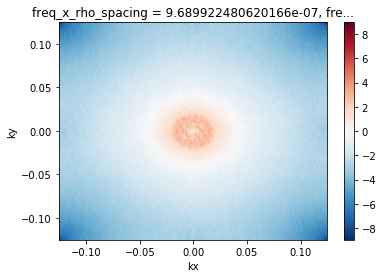

In [91]:
np.log10(ekehat.assign_coords(kx=kx, ky=ky)).plot(x='kx', y='ky') #, subplot_kws={'aspect':'equal'}, aspect=.5, figsize=(5,5))

In [92]:
ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)

In [93]:
def add_slope(kmin, kmax, y0, s):
    if isinstance(s, list):
        [add_slope(kmin, kmax, y0, ls) for ls in s]
    else:
        k = np.arange(kmin,kmax,(kmax-kmin)/3.)
        y = y0*(k/k[0])**s
        plt.plot(k, y, 'k')
        plt.text(k[-1], y[-1], ' {i}'.format(i=s))

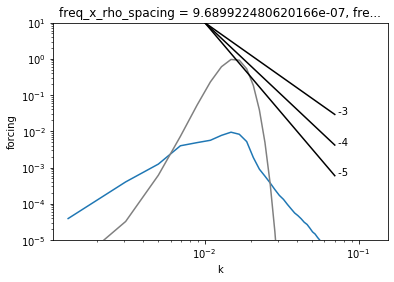

In [94]:
ekehat_iso.plot(x='k', xscale='log', yscale='log')

# get forcing wavenumbers
F_k = 1e3*r.params_output['fst_k']
F_dk = 1e3*r.params_output['fst_dk']
F = np.exp(-((ekehat_iso.k-F_k)/F_dk)**2).rename('forcing')

F.plot(x='k', xscale='log', yscale='log', 
                           ylim=(1e-5, 1e1), color='0.5')

add_slope(1e-2, 1e-1, 1e1, [-3, -4, -5])

In [95]:
u = r['surf']['u'].sel(time=slice(50,1000,100))
v = r['surf']['v'].sel(time=slice(50,1000,100))
uhat2 = xrft.power_spectrum(r.xgrid.interp(u,'xi').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
vhat2 = xrft.power_spectrum(r.xgrid.interp(v,'eta').chunk({'x_rho': None, 'y_rho': None}),
                         dim=['x_rho','y_rho'], detrend='constant', window=True).compute()
ekehat = .5*(uhat2 + vhat2)

ekehat_iso = xrft.isotropize(ekehat, ['freq_y_rho','freq_x_rho'])
ekehat_iso = ekehat_iso.assign_coords(k=ekehat_iso.freq_r*1e3)
ekehat_iso = ekehat_iso.persist()

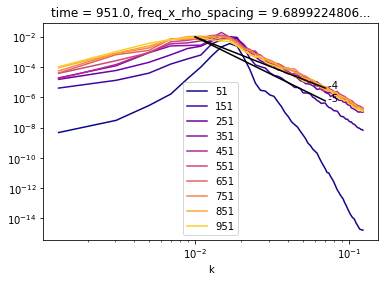

In [96]:
#hdl = ekehat_iso.plot(x='k', hue='time', xscale='log', yscale='log')
#
colors = get_cmap_colors(ekehat_iso.time.size)
for t, c in zip(ekehat_iso.time, colors):
    ekehat_iso.sel(time=t).plot(x='k', color=c,
                                xscale='log', yscale='log',
                                label='{t}'.format(t=int(t)))
plt.legend()
add_slope(1e-2, 1e-1, 1e-2, [-4,-5])

---

## make movies

In [97]:
def plt_atom(da, ax, ax_kwargs, **plt_kwargs):
    #
    xc = next((x for x in da.dims if x[0]=='x'), False)
    yc = next((x for x in da.dims if x[0]=='y'), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time)
    title = da.name+' day = %d'%(d)
    #h = (_da.time-d)*24
    #title = da.name+' day = %d / h = %.2f hour '%(d, h)
    #
    da.plot(x='x',y='y', ax=ax, **plt_kwargs)
    plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect('equal', 'box')
    ax.set(**ax_kwargs)
    ax.set_title(title)

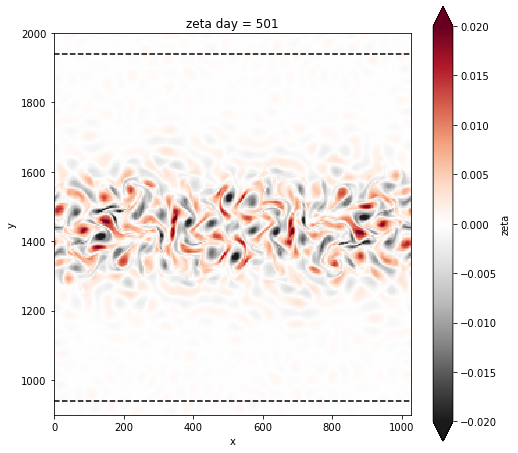

In [101]:
da = (zeta/f_zeta).rename('zeta').isel(time=slice(0,None,1))
plt_kw = {'vmin': -.02, 'vmax': .02, 'cmap': 'RdGy_r', 
          'extend':'both'}
ax_kw = {'ylim': (900, 2000)}
gen_fig(da, i=500, test=True, figsize=(8,8), 
        ax_kwargs=ax_kw, **plt_kw)

In [102]:
fig_wrapper(da, figsize=(8,8),
            ax_kwargs=ax_kw, **plt_kw)

17 batches to be done
 batch 0-58
 batch 59-117
 batch 118-176
 batch 177-235
 batch 236-294
 batch 295-353
 batch 354-412
 batch 413-471
 batch 472-530
 batch 531-589
 batch 590-648
 batch 649-707
 batch 708-766
 batch 767-825
 batch 826-883
 batch 884-941
 batch 942-999


---

In [ ]:
cluster.close()